# Les 3: Modellen robuuster maken

In de voorgaande twee lessen hebben we gekeken hoe je modellen maakt. Nu gaan we leren hoe je ervoor zorgt dat je modellen betrouwbaar zijn.

copy paste readme:

Er zijn allemaal Data Science technieken die ervoor zorgen dat de modellen die je in de vorige les hebt leren maken, betrouwbaarder worden. Je leert hoe je de kwaliteit van je modellen vaststelt en vervolgens wat je moet doen om die kwaliteit te verbeteren. Ook leer je wat je moet doen als de hoeveelheid data die je tot je beschikking hebt beperkt is.

#### Aan het einde van deze les kun je:

- Vaststellen wat de kwaliteit is van je modellen.
- Modellen robuuster en efficiënter maken.
    
#### Onderwerpen

- Confusion matrices
- Wat te doen met outliers en ontbrekende waarden?
- Overfitting
- Sampling density en feature selection
- Train, test, validate

## Uitvoeren op Google Colab

Dit notebook kan worden uitgevoerd op Google Colab. Hiervoor is een Google-account vereist.

Klik op de knop "Open in Google Colab" om het notebook te openen in Google Colab:


<a href="https://colab.research.google.com/github/mcdejonge/beginnen_met_data_science/blob/main/les_3_modellen_robuuster_maken.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In het codeblok hieronder worden alle bibliotheken ingeladen die in dit notebook worden gebruikt.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import os
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split

## 3.1 Hoe goed is je model?

In les 2 hebben we al kennis gemaakt met de functie `score` voor modellen van het type `LinearModel`. Deze functie berekent een numerieke waarde die weergeeft hoe ver de voorspellingen van het model afwijken van de werkelijkheid.

In veel gevallen is één enkel getal echter niet voldoende om inzicht te geven in de prestaties van een model. Voor classificatie-problemen (clustering) is het bijvoorbeeld niet alleen van belang om te weten hoeveel observaties er correct zijn voorspeld, maar ook aan welke categorie de *verkeerd* toegewezen observaties terecht zijn gekomen.

Hiervoor gebruiken we een zogenoemde *confusion matrix*. Een dergelijke matrix geeft weer hoeveel observaties er correct zijn geplaatst in één van twee mogelijke clusters en ook per cluster hoeveel observaties er ten onrechte aan zijn toegewezen. De naam is afkomstig van het gegeven dat het model twee categorieën door elkaar haalt (to confuse = door elkaar halen).

We frissen eerst ons geheugen op wat de score voor een lineair model ook al weer was en gaan daarna dieper in op confusion matrices.

### 3.1.1 $R^2$ (herhaling vorige les)

In de vorige les hebben we gezien dat je kunt achterhalen hoe goed een lineair model nieuwe waarden voorspelt door de zogenoemde $R^2$ waarde (R Squared) te berekenen. Deze meetwaarde geeft aan hoe dicht de daadwerkelijke datapunten liggen bij de lijn van het model. Is de $R^2$ gelijk aan 1 dan vallen ze precies samen en is $R^2$ gelijk aan 0 dan is er geen enkele relatie tussen de lijn en de datapunten.

Hieronder zie je een paar voorbeelden. De code die hiervoor wordt gebruikt, hoef je niet te bestuderen: het gaat om de grafieken.


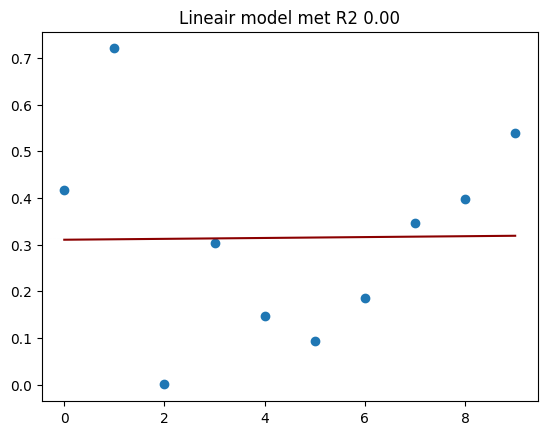

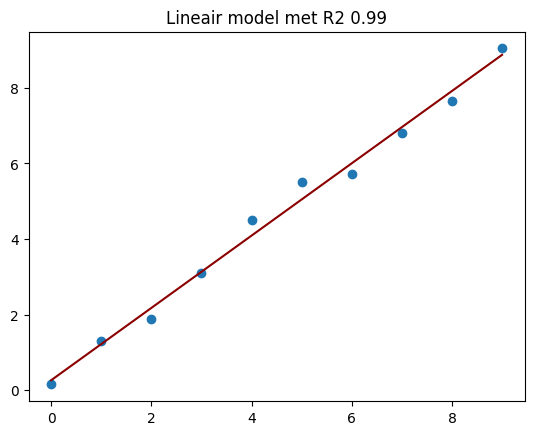

In [2]:

# Genereer 10 willekeurige getallen en laat zien dat de R2-score laag is als je er een lineair model voor maakt.
np.random.seed(1)
df_getallen_willekeurig = pd.DataFrame({
    'x' : range(0,10),
    'y': np.random.random(10)
})
model1 = LinearRegression()
model1.fit(df_getallen_willekeurig[['x']], df_getallen_willekeurig[['y']])
fig, ax = plt.subplots()
plt.scatter(df_getallen_willekeurig['x'], df_getallen_willekeurig['y'])
plt.plot(df_getallen_willekeurig['x'], model1.predict(df_getallen_willekeurig[['x']]), color='darkred')
ax.set_title(f"Lineair model met R2 {model1.score(df_getallen_willekeurig[['x']], df_getallen_willekeurig[['y']]):.2f}")
plt.show()

# En laat zien hoe een hoge R2-score eruit ziet
np.random.seed(3)
df_getallen = pd.DataFrame({
    'x' : range(0, 10),
    'y' : [i + (np.random.random() - 0.4) for i in range(0, 10)]
})
model2 = LinearRegression()
model2.fit(df_getallen[['x']], df_getallen[['y']])
fig, ax = plt.subplots()
plt.scatter(df_getallen['x'], df_getallen['y'])
plt.plot(df_getallen['x'], model2.predict(df_getallen[['x']]), color='darkred')
ax.set_title(f"Lineair model met R2 {model2.score(df_getallen[['x']], df_getallen[['y']]):.2f}")
plt.show()



We zien dat een lineair model met een lage $R^2$ geen enkele voorspellende waarde heeft terwijl de datapunten bij een model met een hoge $R^2$ zo dicht op de lijn liggen dat het voor de hand ligt te verwachten dat dat voor nog te voorspellen datapunten ook het geval zal zijn.



Gebruik je een `LinearRegression`-model in Python dan bereken je de $R^2$-waarde met de methode `score`. Deze krijgt als parameters de voorspelde waarden en de echte waarden, zoals in het voorbeeld hieronder:

In [3]:
df = pd.DataFrame({
    'x' : [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'y' : [9, 9, 7, 7, 6, 6, 3, 3, 1]
})
model = LinearRegression()
model.fit(df[['x']], df[['y']])
model.score(df[['x']], df[['y']])


0.935752688172043

### 3.1.2 Confusion matrix

$R^2$ is alleen geschikt als maatstaf voor de kwaliteit van een lineair regressiemodel. Voor andere typen modellen, zoals classificatiemodellen, moet je op een andere manier berekenen wat de kwaliteit is, en wel door gebruik te maken van iets dat een *confusion matrix* is.

Om uit te leggen wat een confusion matrix is en hoe je ermee werkt, gebruiken we opnieuw de supermarktdata uit de vorige les. Dit is data van een fictieve supermarkt waarin voor 10 klanten is vastgelegd hoeveel diepvriespizza's en pakken hagelslag ze hebben gekocht. In tegenstelling tot in de vorige les weten we nu echter ook of elke klant kinderen heeft of niet. Wat we nu willen gaan doen is een model maken dat voorspelt of een klant kinderen heeft of niet door uitsluitend te kijken naar zijn of haar koopgedrag voor diepvriespizza's en pakken hagelslag. De reden hiervoor is dat lang niet alle klanten geneigd zijn de supermarkt te vertellen of ze kinderen hebben of niet maar dat de supermarkt dat toch graag zou willen weten zodat ze gericht reclame kunnen maken voor producten die voor ouders met kinderen relevant zijn.

Net als in de vorige les maken we een model met K-means clustering. Vervolgens maken we een confusion matrix om de kwaliteit van het model te beoordelen.

In [4]:
# Inlezen van supermarktdata. 
if 'COLAB_GPU' in os.environ:
    dfsuper = pd.read_csv("https://raw.githubusercontent.com/mcdejonge/beginnen_met_data_science/refs/heads/main/data/supermarkt.csv")
else:
    dfsuper = pd.read_csv("data/supermarkt.csv")
dfsuper

,klant,diepvriespizza,hagelslag,kinderen
0,k1,5,9,1
1,k2,6,10,1
2,k3,4,8,1
3,k4,5,6,0
4,k5,3,8,1
5,k6,9,4,0
6,k7,11,3,0
7,k8,12,4,1
8,k9,14,2,0
9,k10,10,4,0


In [5]:
# Net als in de vorige les maken we een nieuw KMeans-model aan dat onze data opdeelt in twee clusters.
kmeans = KMeans(n_clusters = 2)
# Train het model op de twee numerieke kolommen van de supermarktdata.
kmeans.fit(dfsuper[['diepvriespizza', 'hagelslag']])

# Voor het overzicht gebruiken we de functie `assign` om de voorspelde clusters te tonen naast de oorspronkelijke data
dfsuper.assign(cluster = kmeans.predict(dfsuper[['diepvriespizza', 'hagelslag']]))

,klant,diepvriespizza,hagelslag,kinderen,cluster
0,k1,5,9,1,0
1,k2,6,10,1,0
2,k3,4,8,1,0
3,k4,5,6,0,0
4,k5,3,8,1,0
5,k6,9,4,0,1
6,k7,11,3,0,1
7,k8,12,4,1,1
8,k9,14,2,0,1
9,k10,10,4,0,1


Op het oog zien we al dat het model vrij goed werkt maar dat de gevonden clusters niet helemaal overlappen met de waarde in de kolom "kinderen" (1 betekent: "ja" en 0 betekent: "nee").

Een confusion matrix kan ons vertellen hoe groot het verschil precies is.

In [6]:
confusion_matrix = metrics.confusion_matrix(dfsuper[['kinderen']], kmeans.predict(dfsuper[['diepvriespizza', 'hagelslag']]))
confusion_matrix

array([[1, 4],
       [4, 1]])

De betekenis van deze vier getallen is de volgende:

<img src="img/confusion_matrix.png" width="80%">

Gegeven twee categorieën *positive* en *negative*:

- **True Positive**: correct voorspeld als *positive*.
- **True Negative**: correct voorspeld als *negative*.
- **False Positive**: waarde is *negative* maar onterecht geclassificeerd als *positive*.
- **False Negative**: waarde is *positive* maar onterecht geclassificeerd als *negative*.

In het geval van de supermarktdata is er dus één klant die kinderen heeft maar waarvan het model beweert dat hij of zij dat niet heeft en één klant waarvan het model ten onrechte beweert dat hij of zij kinderen heeft. In cijfers uitgedrukt hebben we 20% van elke categorie (wel kinderen / geen kinderen) verkeerd voorspeld. Wanneer we dit model nu gaan gebruiken om aan 1000 klanten die in de categorie "kinderen" zijn geplaatst proefverpakkingen te sturen met, zeg, liga-koeken, dan verdwijnen er daarvan 200 in de prullebak (of leiden in ieder geval niet tot de aankoop van meer liga-koeken).

Erger wordt het als we een medische test uitvoeren om te bepalen of iemand een aandoening heeft of niet. "False positive" betekent dan: "heeft de aandoening niet maar wordt er toch voor behandeld" - wat een groot probleem is als de behandeling ernstige bijwerkingen heeft. "False negative" (aandoening is niet opgemerkt en patiënt wordt er dus niet voor behandeld) is uiteraard ook erg onwenselijk.

In de praktijk hangt het van de situatie af of een model met een bepaald aantal false positives of false negatives bruikbaar is of niet en waar de nadruk op moet worden gelegd (wat is erger: meer false positives of meer false negatives?). Een confusion matrix helpt je bepalen wat de kwaliteit van je model precies is zodat je een weloverwoge keuze kunt maken om het model daadwerkelijk in te zetten of om een compleet nieuw model te gaan trainen.


### 3.1.3 Code confusion matrix

Helaas heeft Python geen functie aan boord om een mooie, goed leesbare confusion matrix te maken. Hiervoor zul je zelf wat in elkaar moeten knutselen. Dat knutselen valt buiten de scope van deze cursus, vandaar dat hieronder wat code staat die je kunt kopieëren om te gebruiken in je eigen werk. Wanneer je de functie `confusion_matrix_netjes` naar je eigen code kopieert (denk eraan dat je de bijbehorende imports meeneemt!) dan kun je deze aanroepen met als eerste parameter de daadwerkelijke waarden en als tweede parameter de voorspelde waarden.

In [7]:
# Kopieer dit complete code-blok naar je eigen notebook als je de functie confusion_matrix_netjes wil gebruiken.
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# De 
def confusion_matrix_netjes(echte_waarden, voorspelde_waarden):
    """
    Functie om een "nette" confusion matrix weer te geven. De eerste parameter moet de echte waarden bevatten en de tweede parameter de voorspelde waarden. Maakt gebruik van de library "seaborn" (geïmporteerd als "sns"), de library numpy (geïmporteerd als "np") en van de functie "confusion_matrix" uit de library "sklearn.
    """
    try:
        cf_matrix = confusion_matrix(echte_waarden, voorspelde_waarden)
    except Exception as e:
        print("Maken confusion matrix mislukt. Kloppen de parameters?")
        raise e
    
    labels = np.asarray(
        ['True Neg {perc:.0f}%'.format(perc = (cf_matrix[0][0] / len(echte_waarden) * 100)), 
         'False Pos {perc:.0f}%'.format(perc = (cf_matrix[0][1] / len(echte_waarden) * 100)), 
         'False Neg {perc:.0f}%'.format(perc = (cf_matrix[1][0] / len(echte_waarden) * 100)), 
         'True Pos {perc:.0f}%'.format(perc = (cf_matrix[1][1] / len(echte_waarden) * 100))]).reshape(2, 2)
    sns.heatmap(cf_matrix, annot = labels, fmt='', cmap = 'Blues')


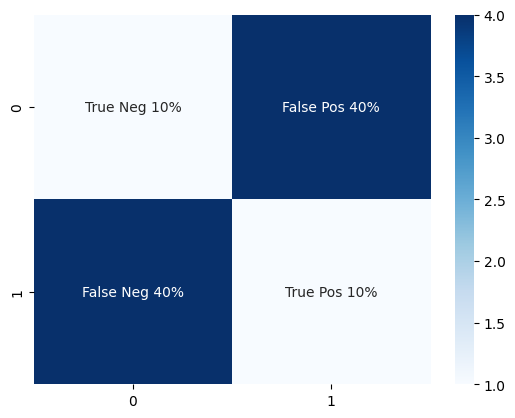

In [8]:
# Hier zien we een voorbeeld van een aanroep van de functie
# confusion_matrix_netjes
confusion_matrix_netjes(dfsuper[['kinderen']], kmeans.predict(dfsuper[['diepvriespizza', 'hagelslag']]))
    


### 3.1.4 Opgave

Gebruik de functie `confusion_matrix_netjes` om de kwaliteit vast te stellen van een model dat lijkt op het model dat je tijdens de vorige les hebt gemaakt om met behulp van K-means clustering pinguïns te herkennen.

Er is echter wel een verschil: een confusion matrix kan maar met twee klassen overweg. We kiezen er daarom voor om het model te laten voorspellen of een pinguïn van het soort "Gentoo" is of niet (en we geven de parameter `n_clusters` de waarde 2 om aan te geven dat we maar twee klassen willen hebben).

Verder kan een confusion matrix niet met tekstwaarden overweg. We moeten onze brondata daarom een beetje aanpassen: we voegen een nieuwe kolom toe "is_gentoo" en geven deze de waarde 1 als de pinguïn van het soort "Gentoo" is en de waarde 0 als dat niet het geval is. De code hiervoor vind je hieronder.



In [11]:
# Lees de pinguin-data in
if 'COLAB_GPU' in os.environ:
    df_pinguins = pd.read_csv("https://raw.githubusercontent.com/mcdejonge/beginnen_met_data_science/refs/heads/main/data/palmerpenguins/penguins_size_clean.csv")
else:
    df_pinguins = pd.read_csv("data/palmerpenguins/penguins_size_clean.csv")

In [12]:
# Pas de pinguin-data aan: maak een nieuwe kolom is_gentoo 
# die de waarde 1 bevat als de pinguin van het soort "Gentoo" is 
# en anders 0.
# Hiervoor gebruiken we de functie `np.where`. Als de waarde in 
# de kolom species 'Gentoo' is, krijgt de nieuwe kolom is_gentoo
# de waarde 1, anders 0
df_pinguins['is_gentoo'] = np.where(df_pinguins['species'] == 'Gentoo', 1, 0)
df_pinguins

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,is_gentoo
0,Adelie,Torgersen,39.1,18.7,181,3750,MALE,0
1,Adelie,Torgersen,39.5,17.4,186,3800,FEMALE,0
2,Adelie,Torgersen,40.3,18.0,195,3250,FEMALE,0
3,Adelie,Torgersen,36.7,19.3,193,3450,FEMALE,0
4,Adelie,Torgersen,39.3,20.6,190,3650,MALE,0
...,...,...,...,...,...,...,...,...
337,Gentoo,Biscoe,47.2,13.7,214,4925,FEMALE,1
338,Gentoo,Biscoe,46.8,14.3,215,4850,FEMALE,1
339,Gentoo,Biscoe,50.4,15.7,222,5750,MALE,1
340,Gentoo,Biscoe,45.2,14.8,212,5200,FEMALE,1


In [13]:
# Plaats hier je eigen code




## 3.2 Maar hoe goed is je model nu echt? TODO

Tot nu toe hebben we de kwaliteit van onze modellen berekend door de waarden uit de oorspronkelijke dataset te vergelijken met de voorspelde waarden. Hoewel dat een aardige eerste indruk geeft, zegt dat natuurlijk nog niet zoveel over hoe goed ons model datapunten kan voorspellen die het nog nooit eerder gezien heeft. In de praktijk kan het natuurlijk heel goed zijn dat de datapunten die we hebben gebruikt om het model te trainen (de zogenoemde "trainingsdata") simpelweg vanwege het toeval kenmerken met elkaar gemeen hebben die voor het eigenlijke probleem dat we willen oplossen helemaal niet relevant zijn.

Stel je bijvoorbeeld dat we een model willen leren foto's van honden en wolven van elkaar te onderscheiden. Als alle foto's van wolven genomen zijn in de sneeuw, zal het model leren dat het de aanwezigheid van sneeuw is dat honden van wolven onderscheidt, wat uiteraard niet de bedoeling is (dit is overigens een echt bestaand voorbeeld!).

Op een kleinere schaal kunnen dergelijke problemen ook bij onze eigen data science-werkzaamheden optreden, simpelweg doordat we onze modellen trainen op data die toevallig niet representatief is.

Denk terug aan het voorbeeld van het aantal verkochte ijsjes vs de temperatuur uit de vorige les. In de eerste versie hadden we maar een deel van de gegevens en leek het verband volledig lineair te zijn. Daarna voegden we extra data toe en bleek het verband toch anders te liggen. Hier zien we die verschillen nog een keer:


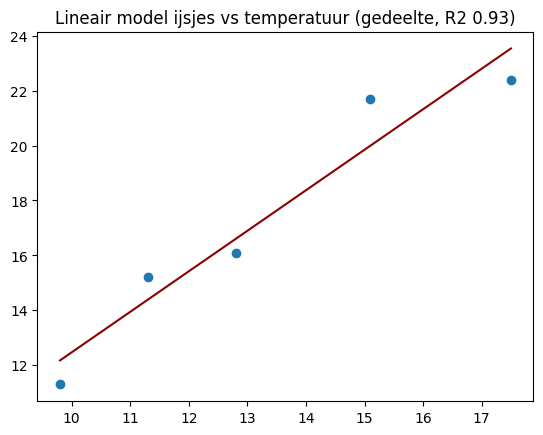

In [14]:
# Een deel van de oorspronkelijke dataset
df_ijsjes_deel = pd.DataFrame({
    'temperatuur' : [9.8,  11.3, 12.8, 15.1, 17.5],
    'ijsjes' :      [ 11.3, 15.2, 16.1, 21.7, 22.4]
})
model = LinearRegression()
model.fit(df_ijsjes_deel[['temperatuur']], df_ijsjes_deel[['ijsjes']])
fig, ax = plt.subplots()
plt.scatter(df_ijsjes_deel['temperatuur'], df_ijsjes_deel['ijsjes'])
plt.plot(df_ijsjes_deel['temperatuur'], model.predict(df_ijsjes_deel[['temperatuur']]), color='darkred')
ax.set_title(f"Lineair model ijsjes vs temperatuur (gedeelte, R2 {model.score(df_ijsjes_deel[['temperatuur']], df_ijsjes_deel[['ijsjes']]):.2f})")
plt.show()

Het model - de rode lijn - sluit vrij goed aan op de datapunten waarop het is getraind.

Wanneer we het model nu echter op de complete dataset plaatsen dan zien we dat het eigenlijk helemaal niet zo goed is:

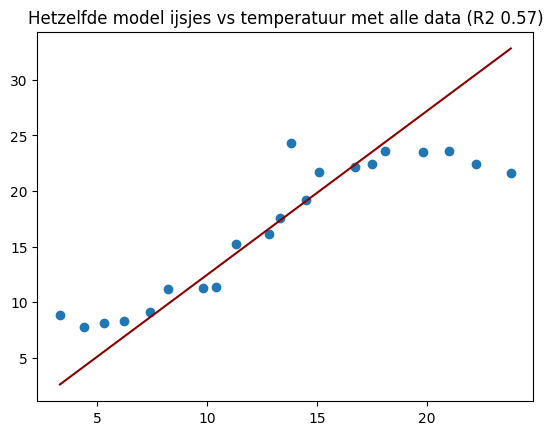

In [15]:
# De dataset met extra observaties toegevoegd
df_ijsjes_alle = pd.DataFrame({
    'temperatuur' : [3.3, 4.4, 5.3, 6.2, 7.4, 8.2,  9.8,  10.4, 11.3, 12.8, 13.3, 13.8, 14.5, 15.1, 16.7, 17.5, 18.1, 19.8, 21.0, 22.2, 23.8 ],
    'ijsjes' :      [8.8, 7.8, 8.1, 8.3, 9.1, 11.2, 11.3, 11.4, 15.2, 16.1, 17.6, 24.3, 19.2, 21.7, 22.2, 22.4, 23.6, 23.5, 23.6, 22.4, 21.6]
})
fig, ax = plt.subplots()
plt.scatter(df_ijsjes_alle['temperatuur'], df_ijsjes_alle['ijsjes'])
plt.plot(df_ijsjes_alle['temperatuur'], model.predict(df_ijsjes_alle[['temperatuur']]), color='darkred')
ax.set_title(f"Hetzelfde model ijsjes vs temperatuur met alle data (R2 {model.score(df_ijsjes_alle[['temperatuur']], df_ijsjes_alle[['ijsjes']]):.2f})")
plt.show()

Zelfs als we buiten beschouwing laten dat de data niet lineair is, is duidelijk dat de helling van de rode lijn (het model) te stijl is.

We zeggen dat het model *overfit* is op de data waarop het is getraind (de *trainingsset*).

Overfitting is een veel-voorkomend probleem, vandaar dat data scientists allemaal technieken hebben ontwikkeld om de effecten ervan tegen te gaan of in ieder geval te beperken.

De belangrijkste van deze technieken is de beschikbare data op te delen in twee afzondelijke datasets: eentje om te *trainen* (de *trainingsset*) en eentje om het getrainde model te *testen* (de *testset*).


### 3.2.1 Train / test split

Opdelen van de data in een trainingsset en een testset is zo gangbaar dat Python er een speciale functie voor heeft: `train_test_split`. Deze is te vinden in de module `sklearn.model_selection`:

`from sklearn.model_selection import train_test_split`

Je gebruikt deze functie als volgt:

In [16]:
df_ijsjes_train, df_ijsjes_test = train_test_split(df_ijsjes_alle)

# Laten we even kijken hoeveel er in de test- en trainingssets zit:
print(f"De trainingsset bevat {len(df_ijsjes_train)} observaties en de testset {len(df_ijsjes_test)}")

De trainingsset bevat 15 observaties en de testset 6


`train_test_split` biedt allemaal opties om heel precies in te stellen wat er in je trainingssets en testssets terechtkomt. Gebruik je echter gewoon de standaardinstellingen, zoals hierboven dan verdeelt de functie de datapunten willekeurig over de trainingsset en over de testset en wordt een kwart van de datapunten aan de testset toegewezen. Dat zien we hierboven terug.

Laten we opnieuw een lineair model trainen maar nu op de trainingsset. Vervolgens kijken we wat de $R^2$-score is van het model wanneer we het toepassen op de testset:

In [17]:
model = LinearRegression()
model.fit(df_ijsjes_train[['temperatuur']], df_ijsjes_train[['ijsjes']])
model.score(df_ijsjes_test[['temperatuur']], df_ijsjes_test[['ijsjes']])

0.8952809172496871

We zien dat de score op datapunten die het model nog niet eerder heeft gezien een stuk beter is dan de vorige keer. Dat komt omdat de trainingsset is samengesteld door een willekeurige steekproef te nemen uit de beschikbare data en niet simpelweg het eerste handjevol datapunten te nemen, zoals hierboven. Hierdoor wordt de kans kleiner dat het model alleen voorbeelden te zien krijgt die erg op elkaar lijken.

Tijdens het ontwikkelen van modellen geldt daarom dat de echte, definitieve score van een model de score is op basis van de testset. Dat is de score waarmee je vaststelt of je model goed is of niet.

### 3.2.2 Opgave

Ook voor het maken van classificatiemodellen (k-means clustering) kun je trainingssets en testssets gebruiken. Deel de pinguïn-data van hierboven op in een trainingsset en een testset, train een kmeans-model op de trainingsset en maak een confusion matrix voor de testset.

Gebruik de kolommen 'culmen_length_mm' en 'flipper_length_mm' om het model te trainen.

Om te kijken wat het model voorspelt voor de testset, gebruik je de methode `predict`

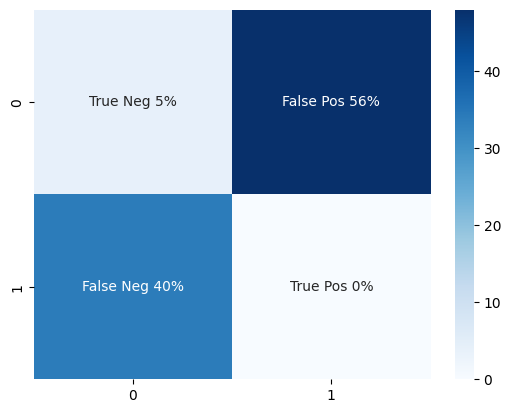

In [ ]:
# Plaats hier je code



## 3.3 Factoren die de kwaliteit van je model beïnvloeden

### 3.3.1 Outliers

### 3.3.2 Ontbrekende waarden